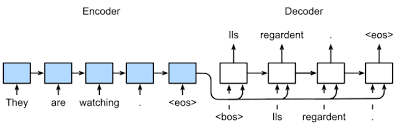

Introduction:
Sequence to Sequence (often abbreviated to seq2seq) models is a special class of Recurrent Neural Network architectures that we typically use (but not restricted) to solve complex Language problems like Machine Translation, Question Answering, creating Chatbots, Text Summarization, etc.


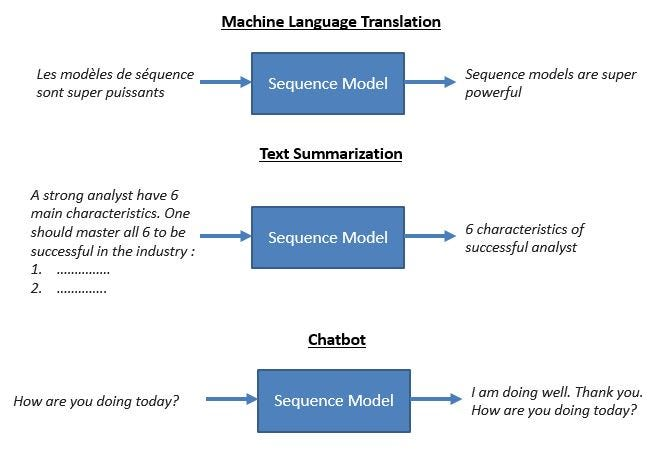

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

# Sample data: English to French sentences (just for demonstration)
english_texts = ['hello', 'how are you', 'good morning']
french_texts = ['bonjour', 'comment ca va', 'bon matin']

# Tokenization
eng_tokenizer = Tokenizer(char_level=True)
eng_tokenizer.fit_on_texts(english_texts)
eng_seq = eng_tokenizer.texts_to_sequences(english_texts)

fr_tokenizer = Tokenizer(char_level=True)
fr_tokenizer.fit_on_texts(french_texts)
fr_seq = fr_tokenizer.texts_to_sequences(french_texts)

# Padding
eng_seq_padded = pad_sequences(eng_seq, padding='post')
fr_seq_padded = pad_sequences(fr_seq, padding='post')

max_eng_seq_length = eng_seq_padded.shape[1]
max_fr_seq_length = fr_seq_padded.shape[1]
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1


embedding_dim = 256
latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(eng_vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]


# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(fr_vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(fr_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')



# Convert target sequences to one-hot vectors
decoder_targets_one_hot = np.zeros((len(fr_seq), max_fr_seq_length, fr_vocab_size), dtype='float32')
for i, sequence in enumerate(fr_seq_padded):
    for t, word_id in enumerate(sequence):
        if word_id > 0:
            decoder_targets_one_hot[i, t, word_id] = 1.0

# Shift decoder input data one step ahead for teacher forcing
decoder_input_data = np.zeros_like(fr_seq_padded)
decoder_input_data[:, 1:] = fr_seq_padded[:, :-1]

# Training
model.fit([eng_seq_padded, decoder_input_data], decoder_targets_one_hot, batch_size=32, epochs=100)


Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 2.0128
Epoch 2/100
1/1 [==============================] - 0s 86ms/step - loss: 1.9935
Epoch 3/100
1/1 [==============================] - 0s 85ms/step - loss: 1.9768
Epoch 4/100
1/1 [==============================] - 0s 90ms/step - loss: 1.9593
Epoch 5/100
1/1 [==============================] - 0s 83ms/step - loss: 1.9390
Epoch 6/100
1/1 [==============================] - 0s 80ms/step - loss: 1.9130
Epoch 7/100
1/1 [==============================] - 0s 83ms/step - loss: 1.8766
Epoch 8/100
1/1 [==============================] - 0s 77ms/step - loss: 1.8212
Epoch 9/100
1/1 [==============================] - 0s 80ms/step - loss: 1.7446
Epoch 10/100
1/1 [==============================] - 0s 113ms/step - loss: 1.6766
Epoch 11/100
1/1 [==============================] - 0s 84ms/step - loss: 1.6308
Epoch 12/100
1/1 [==============================] - 0s 82ms/step - loss: 1.5865
Epoch 13/100
1/1 [==============================] 

In [ ]:
# Encoder inference model
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder inference model
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = Embedding(fr_vocab_size, embedding_dim)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

def decode_sequence(input_seq):
    # Encode the input as state vectors
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))
    # Start with a token (e.g., using '1' for start token if you have one; else, adapt accordingly)
    target_seq[0, 0] = 1

    # Sampling loop for a batch of sequences
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token (using argmax here; sampling methods can vary)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = fr_tokenizer.index_word[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length or find stop character
        if sampled_char == '<end>' or len(decoded_sentence) > max_fr_seq_length: # Replace '<end>' with your sequence's end token
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence


In [ ]:
input_sentence = "hello"
input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
input_seq = pad_sequences(input_seq, maxlen=max_eng_seq_length, padding='post')

decoded_sentence = decode_sequence(input_seq)
print('Input:', input_sentence)
print('Decoded:', decoded_sentence)


1/1 [==============================] - 0s 27ms/step
Input: hello
Decoded: bonjouraaaaaaa


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Data Preprocessing
english_texts = [
    'hello', 'how are you', 'good morning',
    'good evening', 'what is your name', 'thank you', 'see you later'
]
french_texts = [
    'bonjour', 'comment ca va', 'bon matin',
    'bon soir', 'quel est votre nom', 'merci', 'a bientot'
]

eng_tokenizer = Tokenizer(char_level=True)
eng_tokenizer.fit_on_texts(english_texts)
eng_seq = eng_tokenizer.texts_to_sequences(english_texts)

fr_tokenizer = Tokenizer(char_level=True)
fr_tokenizer.fit_on_texts(french_texts)
fr_seq = fr_tokenizer.texts_to_sequences(french_texts)

eng_seq_padded = pad_sequences(eng_seq, padding='post')
fr_seq_padded = pad_sequences(fr_seq, padding='post')

max_eng_seq_length = eng_seq_padded.shape[1]
max_fr_seq_length = fr_seq_padded.shape[1]
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1


# 2. Model Building

embedding_dim = 256
latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(eng_vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(fr_vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(fr_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# Assuming the model architecture is defined above
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

decoder_targets_one_hot = np.zeros((len(fr_seq), max_fr_seq_length, fr_vocab_size), dtype='float32')
for i, sequence in enumerate(fr_seq_padded):
    for t, word_id in enumerate(sequence):
        if word_id > 0:
            decoder_targets_one_hot[i, t, word_id] = 1.0

decoder_input_data = np.zeros_like(fr_seq_padded)
decoder_input_data[:, 1:] = fr_seq_padded[:, :-1]

model.fit([eng_seq_padded, decoder_input_data], decoder_targets_one_hot, batch_size=32, epochs=100)

# 4. Inference Setup

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = Embedding(fr_vocab_size, embedding_dim)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs2] + decoder_states2)

# 5. Decode Sequence Function
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = 1
    stop_condition = False
    decoded_sentence = ''
    consecutive_repeat = 0
    prev_token = None
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = fr_tokenizer.index_word.get(sampled_token_index, '?')

        if prev_token == sampled_token_index:
            consecutive_repeat += 1
        else:
            consecutive_repeat = 0
        prev_token = sampled_token_index

        if consecutive_repeat > 2:
            break

        decoded_sentence += sampled_char

        if len(decoded_sentence) > max_fr_seq_length:
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence



input_sentence = "hello"
input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
input_seq = pad_sequences(input_seq, maxlen=max_eng_seq_length, padding='post')

decoded_sentence = decode_sequence(input_seq)
print('Decoded before post-processing:', decoded_sentence)
print('Decoded after post-processing:', post_process(decoded_sentence))


Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 1.5829
Epoch 2/100
1/1 [==============================] - 0s 178ms/step - loss: 1.5741
Epoch 3/100
1/1 [==============================] - 0s 182ms/step - loss: 1.5666
Epoch 4/100
1/1 [==============================] - 0s 183ms/step - loss: 1.5584
Epoch 5/100
1/1 [==============================] - 0s 180ms/step - loss: 1.5478
Epoch 6/100
1/1 [==============================] - 0s 181ms/step - loss: 1.5305
Epoch 7/100
1/1 [==============================] - 0s 193ms/step - loss: 1.4960
Epoch 8/100
1/1 [==============================] - 0s 178ms/step - loss: 1.4679
Epoch 9/100
1/1 [==============================] - 0s 180ms/step - loss: 1.4455
Epoch 10/100
1/1 [==============================] - 0s 179ms/step - loss: 1.4356
Epoch 11/100
1/1 [==============================] - 0s 178ms/step - loss: 1.4202
Epoch 12/100
1/1 [==============================] - 0s 176ms/step - loss: 1.4125
Epoch 13/100
1/1 [======================

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

# 1. Data Preprocessing

english_texts = [
    'hello', 'how are you', 'good morning',
    'good evening', 'what is your name', 'thank you', 'see you later'
]
french_texts = [
    'bonjour', 'comment ca va', 'bon matin',
    'bon soir', 'quel est votre nom', 'merci', 'a bientot'
]

eng_tokenizer = Tokenizer(char_level=True)
eng_tokenizer.fit_on_texts(english_texts)
eng_seq = eng_tokenizer.texts_to_sequences(english_texts)

fr_tokenizer = Tokenizer(char_level=True)
fr_tokenizer.fit_on_texts(french_texts)
fr_seq = fr_tokenizer.texts_to_sequences(french_texts)

eng_seq_padded = pad_sequences(eng_seq, padding='post')
fr_seq_padded = pad_sequences(fr_seq, padding='post')

max_eng_seq_length = eng_seq_padded.shape[1]
max_fr_seq_length = fr_seq_padded.shape[1]
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

# 2. Model Building

embedding_dim = 128
latent_dim = 128

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(eng_vocab_size, embedding_dim)(encoder_inputs)
enc_dropout = Dropout(0.2)(enc_emb)
encoder_lstm = LSTM(latent_dim, return_state=True, dropout=0.2, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoder_lstm(enc_dropout)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(fr_vocab_size, embedding_dim)(decoder_inputs)
dec_dropout = Dropout(0.2)(dec_emb)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_dropout, initial_state=encoder_states)
decoder_dense = Dense(fr_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 3. Train the Model

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

decoder_targets_one_hot = np.zeros((len(fr_seq), max_fr_seq_length, fr_vocab_size), dtype='float32')
for i, sequence in enumerate(fr_seq_padded):
    for t, word_id in enumerate(sequence):
        if word_id > 0:
            decoder_targets_one_hot[i, t, word_id] = 1.0

decoder_input_data = np.zeros_like(fr_seq_padded)
decoder_input_data[:, 1:] = fr_seq_padded[:, :-1]

model.fit([eng_seq_padded, decoder_input_data], decoder_targets_one_hot, batch_size=16, epochs=100)

# 4. Inference Setup

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
dec_emb2 = Embedding(fr_vocab_size, embedding_dim)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs2] + decoder_states2)

# 5. Decoding Function

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = 1
    decoded_sentence = ''
    while True:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = fr_tokenizer.index_word.get(sampled_token_index, '?')
        decoded_sentence += sampled_char
        if len(decoded_sentence) > max_fr_seq_length:
            break
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence

def post_process(decoded_sentence):
    return re.sub(r'(.)\1+', r'\1', decoded_sentence)

input_sentence = "hello"
input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
input_seq = pad_sequences(input_seq, maxlen=max_eng_seq_length, padding='post')

decoded_sentence = decode_sequence(input_seq)
print('Decoded before post-processing:', decoded_sentence)
print('Decoded after post-processing:', post_process(decoded_sentence))


Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 1.5852
Epoch 2/100
1/1 [==============================] - 0s 80ms/step - loss: 1.5797
Epoch 3/100
1/1 [==============================] - 0s 82ms/step - loss: 1.5750
Epoch 4/100
1/1 [==============================] - 0s 97ms/step - loss: 1.5716
Epoch 5/100
1/1 [==============================] - 0s 81ms/step - loss: 1.5672
Epoch 6/100
1/1 [==============================] - 0s 84ms/step - loss: 1.5632
Epoch 7/100
1/1 [==============================] - 0s 106ms/step - loss: 1.5574
Epoch 8/100
1/1 [==============================] - 0s 87ms/step - loss: 1.5519
Epoch 9/100
1/1 [==============================] - 0s 83ms/step - loss: 1.5401
Epoch 10/100
1/1 [==============================] - 0s 84ms/step - loss: 1.5225
Epoch 11/100
1/1 [==============================] - 0s 83ms/step - loss: 1.4957
Epoch 12/100
1/1 [==============================] - 0s 83ms/step - loss: 1.4826
Epoch 13/100
1/1 [==============================] 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Data Preprocessing

english_texts = ['hello', 'how are you', 'good morning']
french_texts = ['bonjour', 'comment ca va', 'bon matin']

eng_tokenizer = Tokenizer(char_level=True)
eng_tokenizer.fit_on_texts(english_texts)
eng_seq = eng_tokenizer.texts_to_sequences(english_texts)

fr_tokenizer = Tokenizer(char_level=True)
fr_tokenizer.fit_on_texts(french_texts)
fr_seq = fr_tokenizer.texts_to_sequences(french_texts)

eng_seq_padded = pad_sequences(eng_seq, padding='post')
fr_seq_padded = pad_sequences(fr_seq, padding='post')

max_eng_seq_length = eng_seq_padded.shape[1]
max_fr_seq_length = fr_seq_padded.shape[1]
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

# 2. Model Building

embedding_dim = 256
latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(eng_vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(fr_vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(fr_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# 3. Data Preparation for Training

decoder_targets_one_hot = np.zeros((len(fr_seq), max_fr_seq_length, fr_vocab_size), dtype='float32')
for i, sequence in enumerate(fr_seq_padded):
    for t, word_id in enumerate(sequence):
        if word_id > 0:
            decoder_targets_one_hot[i, t, word_id] = 1.0

decoder_input_data = np.zeros_like(fr_seq_padded)
decoder_input_data[:, 1:] = fr_seq_padded[:, :-1]

model.fit([eng_seq_padded, decoder_input_data], decoder_targets_one_hot, batch_size=32, epochs=100)

# 4. Inference Setup

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = Embedding(fr_vocab_size, embedding_dim)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs2] + decoder_states2)

# 5. Decode Sequence Function

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = 1
    stop_condition = False
    decoded_sentence = ''
    consecutive_repeat = 0
    prev_token = None
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = fr_tokenizer.index_word.get(sampled_token_index, '?')
        decoded_sentence += sampled_char

        if prev_token == sampled_token_index:
            consecutive_repeat += 1
        else:
            consecutive_repeat = 0
        prev_token = sampled_token_index

        if consecutive_repeat > 2 or len(decoded_sentence) > max_fr_seq_length:
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence

# 6. Test

input_sentence = "hello"
input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
input_seq = pad_sequences(input_seq, maxlen=max_eng_seq_length, padding='post')

decoded_sentence = decode_sequence(input_seq)
print('Input:', input_sentence)
print('Decoded:', decoded_sentence)


Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 2.0117
Epoch 2/100
1/1 [==============================] - 0s 95ms/step - loss: 1.9927
Epoch 3/100
1/1 [==============================] - 0s 88ms/step - loss: 1.9763
Epoch 4/100
1/1 [==============================] - 0s 78ms/step - loss: 1.9593
Epoch 5/100
1/1 [==============================] - 0s 85ms/step - loss: 1.9400
Epoch 6/100
1/1 [==============================] - 0s 86ms/step - loss: 1.9161
Epoch 7/100
1/1 [==============================] - 0s 97ms/step - loss: 1.8847
Epoch 8/100
1/1 [==============================] - 0s 85ms/step - loss: 1.8408
Epoch 9/100
1/1 [==============================] - 0s 82ms/step - loss: 1.7817
Epoch 10/100
1/1 [==============================] - 0s 85ms/step - loss: 1.7198
Epoch 11/100
1/1 [==============================] - 0s 81ms/step - loss: 1.6625
Epoch 12/100
1/1 [==============================] - 0s 90ms/step - loss: 1.6237
Epoch 13/100
1/1 [==============================] -

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Embedding, Dropout, Attention, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

# 1. Data Preprocessing

english_texts = [
    'hello', 'how are you', 'good morning',
    'good evening', 'what is your name', 'thank you', 'see you later',
    'I am fine', 'have a nice day', 'what time is it', 'where are you',
    'yes', 'no', 'maybe', 'I love you', 'goodbye', 'please', 'sorry',
    'I am happy', 'do you speak English',
    'hello', 'hello, how are you', 'hello', 'hello', 'hello',  # Add repeated 'hello'
]
french_texts = [
    'bonjour', 'comment ca va', 'bon matin',
    'bon soir', 'quel est votre nom', 'merci', 'a bientot',
    'je vais bien', 'passez une bonne journée', 'quelle heure est-il', 'où es-tu',
    'oui', 'non', 'peut-être', 'je t aime', 'au revoir', 's il vous plaît', 'pardon',
    'je suis content', 'parlez-vous anglais',
    'bonjour', 'bonjour comment allez-vous', 'bonjour', 'bonjour', 'bonjour',  # Add repeated 'bonjour'
]


eng_tokenizer = Tokenizer(char_level=True)
eng_tokenizer.fit_on_texts(english_texts)
eng_seq = eng_tokenizer.texts_to_sequences(english_texts)

fr_tokenizer = Tokenizer(char_level=True)
fr_tokenizer.fit_on_texts(french_texts)
fr_seq = fr_tokenizer.texts_to_sequences(french_texts)

eng_seq_padded = pad_sequences(eng_seq, padding='post')
fr_seq_padded = pad_sequences(fr_seq, padding='post')

max_eng_seq_length = eng_seq_padded.shape[1]
max_fr_seq_length = fr_seq_padded.shape[1]
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

embedding_dim = 128
latent_dim = 128

# 2. Model Building with GRU and Attention

def attention_mechanism(encoder_outputs, decoder_gru_out):
    attn_out = Attention(use_scale=True)([decoder_gru_out, encoder_outputs])
    concat_output = Concatenate(axis=-1)([decoder_gru_out, attn_out])
    return concat_output

encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(eng_vocab_size, embedding_dim)(encoder_inputs)
enc_dropout = Dropout(0.2)(enc_emb)
encoder_gru = GRU(latent_dim, return_state=True, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
encoder_outputs, state_h = encoder_gru(enc_dropout)

decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(fr_vocab_size, embedding_dim)(decoder_inputs)
dec_dropout = Dropout(0.2)(dec_emb)
decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_gru_out, _ = decoder_gru(dec_dropout, initial_state=state_h)

attention_output = attention_mechanism(encoder_outputs, decoder_gru_out)
decoder_dense = Dense(fr_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(attention_output)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

decoder_targets_one_hot = np.zeros((len(fr_seq), max_fr_seq_length, fr_vocab_size), dtype='float32')
for i, sequence in enumerate(fr_seq_padded):
    for t, word_id in enumerate(sequence):
        if word_id > 0:
            decoder_targets_one_hot[i, t, word_id] = 1.0

decoder_input_data = np.zeros_like(fr_seq_padded)
decoder_input_data[:, 1:] = fr_seq_padded[:, :-1]

model.fit([eng_seq_padded, decoder_input_data], decoder_targets_one_hot, batch_size=16, epochs=100)
# 3. Inference Setup

# Encoder Inference Model
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h])

# Decoder setup
decoder_state_input = Input(shape=(latent_dim,))
decoder_enc_outputs_input = Input(shape=(None, latent_dim))

# Embedding and GRU
dec_emb2 = Embedding(fr_vocab_size, embedding_dim)(decoder_inputs)
decoder_outputs2, state_h2 = decoder_gru(dec_emb2, initial_state=decoder_state_input)

# Attention
attention_output2 = attention_mechanism(decoder_enc_outputs_input, decoder_outputs2)
decoder_outputs2 = decoder_dense(attention_output2)

decoder_model = Model([decoder_inputs, decoder_state_input, decoder_enc_outputs_input], [decoder_outputs2, state_h2])

# 4. Decoding Function (adjusted to include encoder outputs as input to decoder)



def decode_sequence(input_seq):
    enc_outputs, state_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = 1
    decoded_sentence = ''
    prev_token = ''
    repetition_threshold = 3
    consecutive_repetitions = 0
    while True:
        output_tokens, h = decoder_model.predict([target_seq, state_value, enc_outputs])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = fr_tokenizer.index_word.get(sampled_token_index, '?')

        # Stop condition for excessive repetition
        if sampled_char == prev_token:
            consecutive_repetitions += 1
            if consecutive_repetitions > repetition_threshold:
                break
        else:
            consecutive_repetitions = 0

        decoded_sentence += sampled_char
        prev_token = sampled_char

        if len(decoded_sentence) > max_fr_seq_length:
            break
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        state_value = h
    return decoded_sentence


# The rest of the code remains the same


def post_process(decoded_sentence):
    return re.sub(r'(.)\1+', r'\1', decoded_sentence)

input_sentence = "hello"
input_seq = eng_tokenizer.texts_to_sequences([input_sentence])
input_seq = pad_sequences(input_seq, maxlen=max_eng_seq_length, padding='post')

decoded_sentence = decode_sequence(input_seq)
print(input_sentence , "expected",french_texts[0] )
print('Decoded before post-processing:', decoded_sentence)
print('Decoded after post-processing:', post_process(decoded_sentence))


Epoch 1/100
2/2 [==============================] - 6s 113ms/step - loss: 1.4035
Epoch 2/100
2/2 [==============================] - 0s 117ms/step - loss: 1.3939
Epoch 3/100
2/2 [==============================] - 0s 108ms/step - loss: 1.3854
Epoch 4/100
2/2 [==============================] - 0s 108ms/step - loss: 1.3765
Epoch 5/100
2/2 [==============================] - 0s 112ms/step - loss: 1.3651
Epoch 6/100
2/2 [==============================] - 0s 102ms/step - loss: 1.3467
Epoch 7/100
2/2 [==============================] - 0s 113ms/step - loss: 1.3143
Epoch 8/100
2/2 [==============================] - 0s 104ms/step - loss: 1.2836
Epoch 9/100
2/2 [==============================] - 0s 113ms/step - loss: 1.2629
Epoch 10/100
2/2 [==============================] - 0s 100ms/step - loss: 1.2482
Epoch 11/100
2/2 [==============================] - 0s 107ms/step - loss: 1.2485
Epoch 12/100
2/2 [==============================] - 0s 113ms/step - loss: 1.2369
Epoch 13/100
2/2 [===================

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# 1. Data
english_texts = ["one", "two", "three"]
french_texts = ["un", "deux", "trois"]
french_texts = ['\t' + text + '\n' for text in french_texts]  # Start and end tokens

# 2. Preprocessing
tokenizer_eng = Tokenizer(char_level=True)
tokenizer_eng.fit_on_texts(english_texts)
tokenized_eng = tokenizer_eng.texts_to_sequences(english_texts)
max_len_eng = max([len(text) for text in tokenized_eng])

tokenizer_fr = Tokenizer(char_level=True)
tokenizer_fr.fit_on_texts(french_texts)
tokenized_fr = tokenizer_fr.texts_to_sequences(french_texts)
max_len_fr = max([len(text) for text in tokenized_fr])

encoder_input_data = pad_sequences(tokenized_eng, maxlen=max_len_eng, padding='post')
decoder_input_data = pad_sequences(tokenized_fr, maxlen=max_len_fr, padding='post')
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, :-1] = decoder_input_data[:, 1:]

# 3. Model Building
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(len(tokenizer_eng.word_index) + 1, 50)(encoder_inputs)
encoder_lstm = LSTM(100, return_state=True)
_, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(len(tokenizer_fr.word_index) + 1, 50)(decoder_inputs)
decoder_lstm = LSTM(100, return_sequences=True, return_state=True)
decoder_lstm_out, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(len(tokenizer_fr.word_index)+1, activation="softmax")
decoder_outputs = decoder_dense(decoder_lstm_out)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 4. Training
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
model.fit([encoder_input_data, decoder_input_data], np.expand_dims(decoder_target_data, -1), batch_size=1, epochs=200)

# 5. Inference
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(100,))
decoder_state_input_c = Input(shape=(100,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm_out, state_h, state_c = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_dense_out = decoder_dense(decoder_lstm_out)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_dense_out] + decoder_states)

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer_fr.word_index['\t']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = tokenizer_fr.index_word[sampled_token_index]
        decoded_sentence += sampled_char
        if sampled_char == '\n' or len(decoded_sentence) > max_len_fr:
            stop_condition = True
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence

for seq_index in range(len(english_texts)):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", english_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)



Epoch 1/200
3/3 [==============================] - 5s 9ms/step - loss: 2.5628
Epoch 2/200
3/3 [==============================] - 0s 10ms/step - loss: 2.5382
Epoch 3/200
3/3 [==============================] - 0s 9ms/step - loss: 2.5116
Epoch 4/200
3/3 [==============================] - 0s 13ms/step - loss: 2.4706
Epoch 5/200
3/3 [==============================] - 0s 9ms/step - loss: 2.4170
Epoch 6/200
3/3 [==============================] - 0s 9ms/step - loss: 2.3381
Epoch 7/200
3/3 [==============================] - 0s 10ms/step - loss: 2.1854
Epoch 8/200
3/3 [==============================] - 0s 10ms/step - loss: 1.9719
Epoch 9/200
3/3 [==============================] - 0s 13ms/step - loss: 1.8833
Epoch 10/200
3/3 [==============================] - 0s 9ms/step - loss: 1.8489
Epoch 11/200
3/3 [==============================] - 0s 9ms/step - loss: 1.7924
Epoch 12/200
3/3 [==============================] - 0s 9ms/step - loss: 1.7391
Epoch 13/200
3/3 [==============================] - 0s 9